# DM2: Classification

## In this notebook, we will walk through the creation of different classification models
# Task 1: Building and Evaluating Classification Models

before we do that, we will load the training dataset like below.

In [18]:
import pandas as pd

# Load dataset
df = pd.read_csv("../datasets/graduation_train.csv")
print("Dataset Loaded.")
df.head()

Dataset Loaded.


,student_id,marital_status,application_mode,application_order,course,attendance_type,previous_qualification,nationality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,1,15,1,4,1,14,1,13,27,...,0,6,7,6,13.833333,0,13.9,-0.3,0.79,1
1,2,2,12,1,17,0,1,1,19,24,...,0,5,5,0,0.000000,0,7.6,2.6,0.32,0
2,3,1,1,1,10,1,1,1,1,1,...,0,6,7,6,12.142857,0,11.1,0.6,2.02,1
3,4,1,1,4,12,1,1,1,22,27,...,0,8,8,7,13.381429,0,10.8,1.4,1.74,1
4,5,2,12,1,3,0,9,1,19,24,...,2,6,9,6,12.500000,0,7.6,2.6,0.32,1


There are no missing values, but if this would be the case in the future, they could be either removed or simply be filled in with a default value.

In [19]:
# Default values are defined here so fill in missing values
fill_na = {
    "martial_status": 1,
    "attendance_type":1,
    #...
}
df.fillna(fill_na, inplace=True)

# Drop all rows where student_id is missing
df.dropna(subset=["student_id"], inplace=True)

before we start training the different models, lets prepare the training and test samples.

In [20]:
from sklearn.model_selection import train_test_split

# Drop sensitive features as we do not want bias in our classification models
df = df.drop(columns=["gender", "nationality"])

# Split the dataset into 80% training data and 20% testing data.
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# X = input features used to predict the outcome
# y = target variable (the actual outcome: graduate = 1, drop out = 0)

# For training data:
# Drop the student_id in x since they dont say anything about the student and thus they are useless for the classification model
x_train = df_train.drop(columns=['target', 'student_id'])
# This is the label we want to predict (e.g., 1 = graduate, 0 = drop out)
y_train = df_train['target']

# For testing/validation data:
# Same feature selection for the test set
x_test = df_test.drop(columns=['target', 'student_id'])
# This is the label we want to predict (e.g., 1 = graduate, 0 = drop out)
y_test = df_test['target']



Lets now select the features

In [21]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selects the k best features to work with
selector = SelectKBest(score_func=f_classif, k=10)

# fits selector on training data and transforms the data to only include the selected features, fit
X_train_selected = selector.fit_transform(x_train, y_train)
# Only transforms the data to include the selected features
X_test_selected = selector.transform(x_test)

# get_support returns all (best) selected features
selected_features = x_train.columns[selector.get_support()]

Below, a simple function is written to evaluate future models.

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

model_results = {}

# evaluation function to test different models
def evaluate_model(name, y_true, y_pred, y_probs):
    model_results[name] = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_probs)
    }

    print(f"=== {name} Evaluation ===")
    print("Accuracy:", model_results[name]["Accuracy"])
    print("Precision:", model_results[name]["Precision"])
    print("Recall:", model_results[name]["Recall"])
    print("AUC:", model_results[name]["AUC"])
    print(classification_report(y_true, y_pred))



## Now, we wil test the different models

### - Decision Tree

In [23]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_selected, y_train)

dt_preds = dt_model.predict(X_test_selected)
dt_probs = dt_model.predict_proba(X_test_selected)[:, 1]


# Use the selected feature names
selected_features = x_train.columns[selector.get_support()]

# Export to DOT format
dot_data = export_graphviz(
    dt_model,
    out_file=None,
    feature_names=selected_features,
    class_names=["Drop out", "Passed"],  # Assuming 0 = dropout, 1 = passed
    filled=True,
    rounded=True,
    special_characters=True
)

# Render with graphviz
graph = graphviz.Source(dot_data)
graph.render("../plots/decision_tree")  # Saves 'decision_tree.pdf'
graph.view()


evaluate_model("Decision Tree", y_test, dt_preds, dt_probs)

=== Decision Tree Evaluation ===
Accuracy: 0.8605851979345955
Precision: 0.8954802259887006
Recall: 0.8781163434903048
AUC: 0.8596952908587258
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       220
           1       0.90      0.88      0.89       361

    accuracy                           0.86       581
   macro avg       0.85      0.85      0.85       581
weighted avg       0.86      0.86      0.86       581



### - k-Nearest Neighbours

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_selected, y_train)

knn_preds = knn_model.predict(X_test_selected)
knn_probs = knn_model.predict_proba(X_test_selected)[:, 1]

evaluate_model("K-Nearest Neighbors", y_test, knn_preds, knn_probs)

=== K-Nearest Neighbors Evaluation ===
Accuracy: 0.8812392426850258
Precision: 0.8668341708542714
Recall: 0.9556786703601108
AUC: 0.9169604633593553
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       220
           1       0.87      0.96      0.91       361

    accuracy                           0.88       581
   macro avg       0.89      0.86      0.87       581
weighted avg       0.88      0.88      0.88       581

Opening in existing browser session.


### - Naïve Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_selected, y_train)

nb_preds = nb_model.predict(X_test_selected)
nb_probs = nb_model.predict_proba(X_test_selected)[:, 1]

evaluate_model("Naïve Bayes", y_test, nb_preds, nb_probs)

=== Naïve Bayes Evaluation ===
Accuracy: 0.8605851979345955
Precision: 0.8608247422680413
Recall: 0.925207756232687
AUC: 0.899792243767313
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       220
           1       0.86      0.93      0.89       361

    accuracy                           0.86       581
   macro avg       0.86      0.84      0.85       581
weighted avg       0.86      0.86      0.86       581



### - Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Predict
rf_preds = rf_model.predict(X_test_selected)
rf_probs = rf_model.predict_proba(X_test_selected)[:, 1]

# Evaluate
evaluate_model("Random Forest", y_test, rf_preds, rf_probs)

=== Random Forest Evaluation ===
Accuracy: 0.9104991394148021
Precision: 0.905511811023622
Recall: 0.9556786703601108
AUC: 0.9388000503651472
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       220
           1       0.91      0.96      0.93       361

    accuracy                           0.91       581
   macro avg       0.91      0.90      0.90       581
weighted avg       0.91      0.91      0.91       581



### - Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_selected, y_train)

gb_preds = gb_model.predict(X_test_selected)
gb_probs = gb_model.predict_proba(X_test_selected)[:, 1]

evaluate_model("Gradient Boosting", y_test, gb_preds, gb_probs)

=== Gradient Boosting Evaluation ===
Accuracy: 0.9104991394148021
Precision: 0.905511811023622
Recall: 0.9556786703601108
AUC: 0.9395366406446739
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       220
           1       0.91      0.96      0.93       361

    accuracy                           0.91       581
   macro avg       0.91      0.90      0.90       581
weighted avg       0.91      0.91      0.91       581



### - AdaBoost

In [28]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train_selected, y_train)

ada_preds = ada_model.predict(X_test_selected)
ada_probs = ada_model.predict_proba(X_test_selected)[:, 1]

evaluate_model("AdaBoost", y_test, ada_preds, ada_probs)

=== AdaBoost Evaluation ===
Accuracy: 0.8950086058519794
Precision: 0.8886010362694301
Recall: 0.9501385041551247
AUC: 0.9385356333417275
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       220
           1       0.89      0.95      0.92       361

    accuracy                           0.90       581
   macro avg       0.90      0.88      0.89       581
weighted avg       0.90      0.90      0.89       581



### - XGBoost (Extreme Gradient Boosting)

In [29]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_selected, y_train)

xgb_preds = xgb_model.predict(X_test_selected)
xgb_probs = xgb_model.predict_proba(X_test_selected)[:, 1]

evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)

/home/nielsvandenbroeck/School/DM/Classification/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


=== XGBoost Evaluation ===
Accuracy: 0.9104991394148021
Precision: 0.9098143236074271
Recall: 0.9501385041551247
AUC: 0.9373016872324351
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       220
           1       0.91      0.95      0.93       361

    accuracy                           0.91       581
   macro avg       0.91      0.90      0.90       581
weighted avg       0.91      0.91      0.91       581



### - Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_selected, y_train)

lr_preds = lr_model.predict(X_test_selected)
lr_probs = lr_model.predict_proba(X_test_selected)[:, 1]

evaluate_model("Logistic Regression", y_test, lr_preds, lr_probs)

=== Logistic Regression Evaluation ===
Accuracy: 0.9053356282271945
Precision: 0.8943298969072165
Recall: 0.961218836565097
AUC: 0.9410538907076302
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       220
           1       0.89      0.96      0.93       361

    accuracy                           0.91       581
   macro avg       0.91      0.89      0.90       581
weighted avg       0.91      0.91      0.90       581



## We can use the results that are gathered in model_results to create some plots and analyse the results

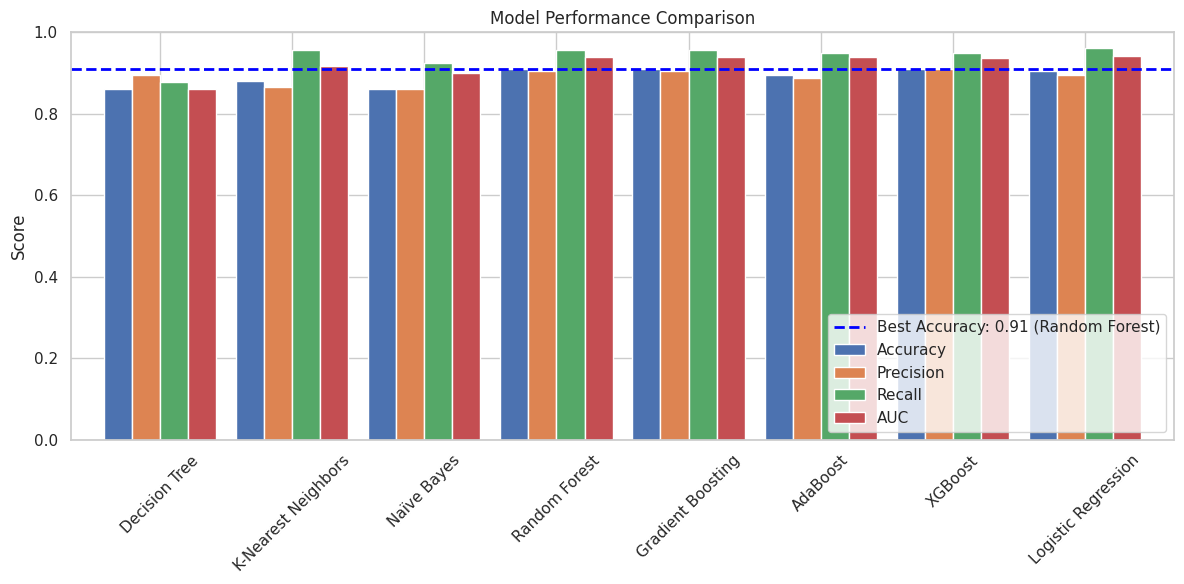

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

results_df = pd.DataFrame(model_results).T

# Plot the bar chart with wider bars
results_df.plot(kind='bar', width=0.85, ax=ax)

best_accuracy = results_df["Accuracy"].max()


# Highlight the best accuracy
ax.axhline(y=best_accuracy, color='blue', linestyle='--', linewidth=2, label=f"Best Accuracy: {best_accuracy:.2f} ({results_df["Accuracy"].idxmax() })")

# Title and formatting
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Legend placement
plt.legend(loc='lower right')
# Save and show
plt.tight_layout()
plt.savefig("../plots/model_comparison_highlighted.png")
plt.show()



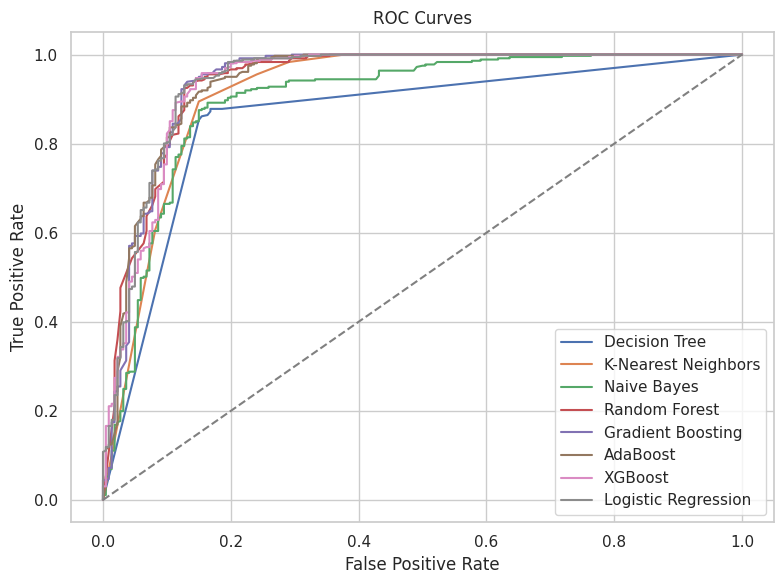

In [32]:
from sklearn.metrics import roc_curve

def plot_roc(y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, label=label)

plt.figure(figsize=(8, 6))
plot_roc(y_test, dt_probs, "Decision Tree")
plot_roc(y_test, knn_probs, "K-Nearest Neighbors")
plot_roc(y_test, nb_probs, "Naive Bayes")
plot_roc(y_test, rf_probs, "Random Forest")
plot_roc(y_test, gb_probs, "Gradient Boosting")
plot_roc(y_test, ada_probs, "AdaBoost")
plot_roc(y_test, xgb_probs, "XGBoost")
plot_roc(y_test, lr_probs, "Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/roc_curves.png")
plt.show()


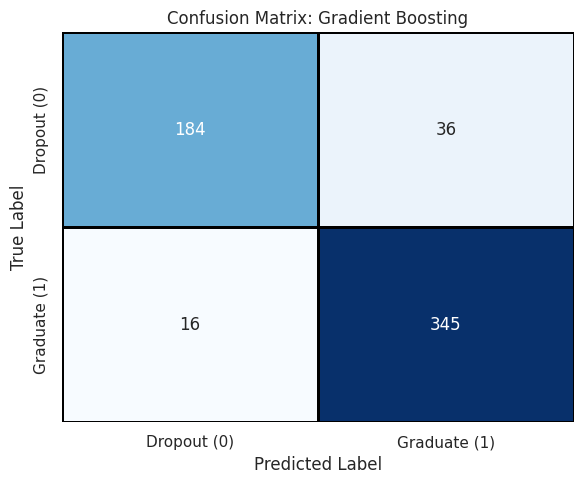

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, gb_preds)  # replace gb_preds with your model's predictions if needed

# Define readable class labels
labels = ["Dropout (0)", "Graduate (1)"]

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=labels, yticklabels=labels, linewidths=1, linecolor='black')

# Labeling
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Gradient Boosting")  # Change model name as needed
plt.tight_layout()

# Save and show
plt.savefig("../plots/confusion_matrix_gradient_boosting.png")
plt.show()


### Lets inspect gender biases


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by gender and calculate graduation rate
gender_graduation_rate = df.groupby('gender')['target'].mean().reset_index()

# Rename for clarity
gender_graduation_rate.columns = ['gender', 'target']

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=gender_graduation_rate, x='gender', y='target', palette='Set2')
plt.title("Graduation Rate by Gender")
plt.ylim(0, 1)
plt.ylabel("Graduation Rate")
plt.xlabel("Gender")

for i, row in gender_graduation_rate.iterrows():
    ax.text(i, row['target'] + 0.02, f"{row['target']:.2f}",
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("../plots/graduation_rate_by_gender.png")
plt.show()


KeyError: 'gender'

# Task 2: Applying the Model to New Student Data

### We will now predict whether students will graduate or not with the best scored model from Part 1

In [64]:
import numpy as np

# Load the test dataset as before
df_test = pd.read_csv("../datasets/graduation_test.csv")
print("Test Dataset Loaded.")
df_test.head()

# Make sure features are the same in new data as model
test_new = df_test.drop(columns=["gender", "nationality"])

# Drop student_id, target is already missing
test_features = test_new.drop(columns=["student_id"])
# Select the features again useing the same selector as before
test_selected = selector.transform(test_features)

# Predict the labels using the best model (gradient boosting)
test_preds = gb_model.predict(test_selected)

# Since graduate = 1 and dropout = 0, we can easily count graduates and dropouts
num_graduates = np.sum(test_preds)
num_dropouts = len(test_preds) - np.sum(test_preds)

print(f"Total students: {len(test_preds)}")
print(f"Predicted to graduate: {num_graduates}")
print(f"Predicted to drop out: {num_dropouts}")

# Prepare to save in csv
predictions_df = pd.DataFrame({
    "student_id": test_new["student_id"],
    "graduation_prediction": test_preds
})

predictions_df.to_csv("../datasets/predictions.csv", index=False)

Test Dataset Loaded.
Total students: 726
Predicted to graduate: 474
Predicted to drop out: 252
